In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_100000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_coords_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 831)
(631390, 1)
validation
(74368, 831)
(74368, 1)
test
(85358, 831)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 831)]             0         


 dense (Dense)               (None, 1024)              851968    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1541121 (5.88 MB)


Trainable params: 1541121 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


1/7 [===>..........................] - ETA: 8s - loss: 0.0970 - STD: 4.0232e-04 - MAE: 0.3004

2/7 [=======>......................] - ETA: 6s - loss: 0.0353 - STD: 5.8587e-04 - MAE: 0.2040

3/7 [===========>..................] - ETA: 2s - loss: 0.0277 - STD: 5.7266e-04 - MAE: 0.1614

4/7 [================>.............] - ETA: 1s - loss: 0.0275 - STD: 5.0915e-04 - MAE: 0.1513

5/7 [====================>.........] - ETA: 0s - loss: 0.0286 - STD: 4.4597e-04 - MAE: 0.1490

6/7 [========================>.....] - ETA: 0s - loss: 0.0296 - STD: 3.9278e-04 - MAE: 0.1486

7/7 [==============================] - ETA: 0s - loss: 0.0303 - STD: 3.5127e-04 - MAE: 0.1483

7/7 [==============================] - 4s 449ms/step - loss: 0.0303 - STD: 3.5127e-04 - MAE: 0.1483 - val_loss: 0.0386 - val_STD: 9.7609e-05 - val_MAE: 0.1482


Epoch 2/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0320 - STD: 1.1117e-04 - MAE: 0.1397

2/7 [=======>......................] - ETA: 0s - loss: 0.0305 - STD: 1.2533e-04 - MAE: 0.1342

3/7 [===========>..................] - ETA: 0s - loss: 0.0288 - STD: 1.4219e-04 - MAE: 0.1272

4/7 [================>.............] - ETA: 0s - loss: 0.0268 - STD: 1.5984e-04 - MAE: 0.1188

5/7 [====================>.........] - ETA: 0s - loss: 0.0249 - STD: 1.7744e-04 - MAE: 0.1097

7/7 [==============================] - ETA: 0s - loss: 0.0224 - STD: 2.0973e-04 - MAE: 0.0965

7/7 [==============================] - 1s 181ms/step - loss: 0.0224 - STD: 2.0973e-04 - MAE: 0.0965 - val_loss: 0.0169 - val_STD: 3.2457e-04 - val_MAE: 0.0942


Epoch 3/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0133 - STD: 3.1735e-04 - MAE: 0.0849

2/7 [=======>......................] - ETA: 0s - loss: 0.0142 - STD: 3.2279e-04 - MAE: 0.0934

3/7 [===========>..................] - ETA: 0s - loss: 0.0151 - STD: 3.2732e-04 - MAE: 0.1004

4/7 [================>.............] - ETA: 0s - loss: 0.0159 - STD: 3.3138e-04 - MAE: 0.1052

6/7 [========================>.....] - ETA: 0s - loss: 0.0161 - STD: 3.3897e-04 - MAE: 0.1081

7/7 [==============================] - ETA: 0s - loss: 0.0158 - STD: 3.4246e-04 - MAE: 0.1068

7/7 [==============================] - 1s 178ms/step - loss: 0.0158 - STD: 3.4246e-04 - MAE: 0.1068 - val_loss: 0.0170 - val_STD: 3.8092e-04 - val_MAE: 0.0960


Epoch 4/10000


1/7 [===>..........................] - ETA: 0s - loss: 0.0135 - STD: 3.6898e-04 - MAE: 0.0870

2/7 [=======>......................] - ETA: 1s - loss: 0.0129 - STD: 3.6901e-04 - MAE: 0.0811

3/7 [===========>..................] - ETA: 0s - loss: 0.0128 - STD: 3.6876e-04 - MAE: 0.0763

4/7 [================>.............] - ETA: 0s - loss: 0.0129 - STD: 3.6859e-04 - MAE: 0.0725

5/7 [====================>.........] - ETA: 0s - loss: 0.0131 - STD: 3.6881e-04 - MAE: 0.0700

6/7 [========================>.....] - ETA: 0s - loss: 0.0132 - STD: 3.6973e-04 - MAE: 0.0683

7/7 [==============================] - ETA: 0s - loss: 0.0134 - STD: 3.7176e-04 - MAE: 0.0673

7/7 [==============================] - 1s 212ms/step - loss: 0.0134 - STD: 3.7176e-04 - MAE: 0.0673 - val_loss: 0.0192 - val_STD: 4.1172e-04 - val_MAE: 0.0720


Epoch 5/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0140 - STD: 3.9606e-04 - MAE: 0.0604

2/7 [=======>......................] - ETA: 0s - loss: 0.0142 - STD: 4.0592e-04 - MAE: 0.0607

3/7 [===========>..................] - ETA: 0s - loss: 0.0141 - STD: 4.1633e-04 - MAE: 0.0605

5/7 [====================>.........] - ETA: 0s - loss: 0.0138 - STD: 4.4156e-04 - MAE: 0.0607

6/7 [========================>.....] - ETA: 0s - loss: 0.0136 - STD: 4.5572e-04 - MAE: 0.0614

7/7 [==============================] - ETA: 0s - loss: 0.0134 - STD: 4.7062e-04 - MAE: 0.0626

7/7 [==============================] - 1s 183ms/step - loss: 0.0134 - STD: 4.7062e-04 - MAE: 0.0626 - val_loss: 0.0166 - val_STD: 6.1784e-04 - val_MAE: 0.0848


Epoch 6/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0128 - STD: 5.9392e-04 - MAE: 0.0747

2/7 [=======>......................] - ETA: 0s - loss: 0.0128 - STD: 6.1173e-04 - MAE: 0.0767

4/7 [================>.............] - ETA: 0s - loss: 0.0129 - STD: 6.4564e-04 - MAE: 0.0800

5/7 [====================>.........] - ETA: 0s - loss: 0.0130 - STD: 6.6171e-04 - MAE: 0.0810

6/7 [========================>.....] - ETA: 0s - loss: 0.0130 - STD: 6.7645e-04 - MAE: 0.0813

7/7 [==============================] - ETA: 0s - loss: 0.0130 - STD: 6.9142e-04 - MAE: 0.0812

7/7 [==============================] - 1s 185ms/step - loss: 0.0130 - STD: 6.9142e-04 - MAE: 0.0812 - val_loss: 0.0166 - val_STD: 8.3422e-04 - val_MAE: 0.0869


Epoch 7/10000


1/7 [===>..........................] - ETA: 0s - loss: 0.0123 - STD: 8.0213e-04 - MAE: 0.0757

2/7 [=======>......................] - ETA: 1s - loss: 0.0126 - STD: 8.1572e-04 - MAE: 0.0746

3/7 [===========>..................] - ETA: 0s - loss: 0.0126 - STD: 8.2862e-04 - MAE: 0.0730

4/7 [================>.............] - ETA: 0s - loss: 0.0127 - STD: 8.4280e-04 - MAE: 0.0716

5/7 [====================>.........] - ETA: 0s - loss: 0.0127 - STD: 8.5729e-04 - MAE: 0.0703

6/7 [========================>.....] - ETA: 0s - loss: 0.0126 - STD: 8.7262e-04 - MAE: 0.0691

7/7 [==============================] - ETA: 0s - loss: 0.0126 - STD: 8.9002e-04 - MAE: 0.0682

7/7 [==============================] - 1s 211ms/step - loss: 0.0126 - STD: 8.9002e-04 - MAE: 0.0682 - val_loss: 0.0171 - val_STD: 0.0011 - val_MAE: 0.0740


Epoch 8/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0130 - STD: 0.0010 - MAE: 0.0634

2/7 [=======>......................] - ETA: 0s - loss: 0.0127 - STD: 0.0011 - MAE: 0.0631

3/7 [===========>..................] - ETA: 0s - loss: 0.0127 - STD: 0.0011 - MAE: 0.0635

5/7 [====================>.........] - ETA: 0s - loss: 0.0127 - STD: 0.0012 - MAE: 0.0649

6/7 [========================>.....] - ETA: 0s - loss: 0.0126 - STD: 0.0012 - MAE: 0.0656

7/7 [==============================] - ETA: 0s - loss: 0.0126 - STD: 0.0013 - MAE: 0.0664

7/7 [==============================] - 1s 179ms/step - loss: 0.0126 - STD: 0.0013 - MAE: 0.0664 - val_loss: 0.0164 - val_STD: 0.0016 - val_MAE: 0.0831


Epoch 9/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0126 - STD: 0.0016 - MAE: 0.0731

2/7 [=======>......................] - ETA: 0s - loss: 0.0125 - STD: 0.0016 - MAE: 0.0735

3/7 [===========>..................] - ETA: 0s - loss: 0.0125 - STD: 0.0017 - MAE: 0.0738

4/7 [================>.............] - ETA: 0s - loss: 0.0125 - STD: 0.0017 - MAE: 0.0739

6/7 [========================>.....] - ETA: 0s - loss: 0.0125 - STD: 0.0018 - MAE: 0.0737

7/7 [==============================] - ETA: 0s - loss: 0.0125 - STD: 0.0019 - MAE: 0.0733

7/7 [==============================] - 1s 181ms/step - loss: 0.0125 - STD: 0.0019 - MAE: 0.0733 - val_loss: 0.0163 - val_STD: 0.0024 - val_MAE: 0.0801


Epoch 10/10000


1/7 [===>..........................] - ETA: 0s - loss: 0.0123 - STD: 0.0023 - MAE: 0.0697

2/7 [=======>......................] - ETA: 1s - loss: 0.0123 - STD: 0.0024 - MAE: 0.0690

3/7 [===========>..................] - ETA: 0s - loss: 0.0123 - STD: 0.0025 - MAE: 0.0684

4/7 [================>.............] - ETA: 0s - loss: 0.0123 - STD: 0.0026 - MAE: 0.0678

5/7 [====================>.........] - ETA: 0s - loss: 0.0122 - STD: 0.0026 - MAE: 0.0674

6/7 [========================>.....] - ETA: 0s - loss: 0.0123 - STD: 0.0027 - MAE: 0.0672

7/7 [==============================] - ETA: 0s - loss: 0.0123 - STD: 0.0028 - MAE: 0.0671

7/7 [==============================] - 1s 216ms/step - loss: 0.0123 - STD: 0.0028 - MAE: 0.0671 - val_loss: 0.0162 - val_STD: 0.0037 - val_MAE: 0.0771


Epoch 11/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0121 - STD: 0.0036 - MAE: 0.0661

2/7 [=======>......................] - ETA: 0s - loss: 0.0121 - STD: 0.0038 - MAE: 0.0668

3/7 [===========>..................] - ETA: 0s - loss: 0.0121 - STD: 0.0039 - MAE: 0.0671

4/7 [================>.............] - ETA: 0s - loss: 0.0121 - STD: 0.0041 - MAE: 0.0675

5/7 [====================>.........] - ETA: 0s - loss: 0.0121 - STD: 0.0043 - MAE: 0.0678

6/7 [========================>.....] - ETA: 0s - loss: 0.0120 - STD: 0.0044 - MAE: 0.0681

7/7 [==============================] - 1s 182ms/step - loss: 0.0120 - STD: 0.0046 - MAE: 0.0684 - val_loss: 0.0157 - val_STD: 0.0063 - val_MAE: 0.0797


Epoch 12/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0116 - STD: 0.0061 - MAE: 0.0691

2/7 [=======>......................] - ETA: 0s - loss: 0.0118 - STD: 0.0064 - MAE: 0.0693

4/7 [================>.............] - ETA: 0s - loss: 0.0117 - STD: 0.0069 - MAE: 0.0684

5/7 [====================>.........] - ETA: 0s - loss: 0.0116 - STD: 0.0072 - MAE: 0.0680

6/7 [========================>.....] - ETA: 0s - loss: 0.0116 - STD: 0.0075 - MAE: 0.0676

7/7 [==============================] - ETA: 0s - loss: 0.0115 - STD: 0.0078 - MAE: 0.0672

7/7 [==============================] - 1s 181ms/step - loss: 0.0115 - STD: 0.0078 - MAE: 0.0672 - val_loss: 0.0150 - val_STD: 0.0108 - val_MAE: 0.0745


Epoch 13/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0112 - STD: 0.0105 - MAE: 0.0642

2/7 [=======>......................] - ETA: 0s - loss: 0.0110 - STD: 0.0109 - MAE: 0.0638

3/7 [===========>..................] - ETA: 0s - loss: 0.0110 - STD: 0.0114 - MAE: 0.0637

4/7 [================>.............] - ETA: 0s - loss: 0.0109 - STD: 0.0120 - MAE: 0.0637

5/7 [====================>.........] - ETA: 0s - loss: 0.0109 - STD: 0.0125 - MAE: 0.0636

6/7 [========================>.....] - ETA: 0s - loss: 0.0108 - STD: 0.0131 - MAE: 0.0635

7/7 [==============================] - 1s 180ms/step - loss: 0.0108 - STD: 0.0138 - MAE: 0.0635 - val_loss: 0.0136 - val_STD: 0.0198 - val_MAE: 0.0726


Epoch 14/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0100 - STD: 0.0192 - MAE: 0.0625

2/7 [=======>......................] - ETA: 0s - loss: 0.0100 - STD: 0.0201 - MAE: 0.0622

3/7 [===========>..................] - ETA: 0s - loss: 0.0098 - STD: 0.0210 - MAE: 0.0618

4/7 [================>.............] - ETA: 0s - loss: 0.0097 - STD: 0.0219 - MAE: 0.0613

5/7 [====================>.........] - ETA: 0s - loss: 0.0096 - STD: 0.0228 - MAE: 0.0606

6/7 [========================>.....] - ETA: 0s - loss: 0.0095 - STD: 0.0238 - MAE: 0.0601

7/7 [==============================] - 1s 183ms/step - loss: 0.0094 - STD: 0.0249 - MAE: 0.0595 - val_loss: 0.0115 - val_STD: 0.0350 - val_MAE: 0.0649


Epoch 15/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0083 - STD: 0.0337 - MAE: 0.0549

2/7 [=======>......................] - ETA: 0s - loss: 0.0082 - STD: 0.0350 - MAE: 0.0545

4/7 [================>.............] - ETA: 0s - loss: 0.0079 - STD: 0.0378 - MAE: 0.0534

5/7 [====================>.........] - ETA: 0s - loss: 0.0077 - STD: 0.0394 - MAE: 0.0530

6/7 [========================>.....] - ETA: 0s - loss: 0.0076 - STD: 0.0409 - MAE: 0.0525

7/7 [==============================] - ETA: 0s - loss: 0.0074 - STD: 0.0424 - MAE: 0.0521

7/7 [==============================] - 1s 178ms/step - loss: 0.0074 - STD: 0.0424 - MAE: 0.0521 - val_loss: 0.0089 - val_STD: 0.0575 - val_MAE: 0.0578


Epoch 16/10000


1/7 [===>..........................] - ETA: 0s - loss: 0.0062 - STD: 0.0540 - MAE: 0.0477

2/7 [=======>......................] - ETA: 1s - loss: 0.0060 - STD: 0.0555 - MAE: 0.0473

3/7 [===========>..................] - ETA: 0s - loss: 0.0060 - STD: 0.0570 - MAE: 0.0469

4/7 [================>.............] - ETA: 0s - loss: 0.0058 - STD: 0.0584 - MAE: 0.0464

5/7 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0598 - MAE: 0.0459

6/7 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0611 - MAE: 0.0455

7/7 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0625 - MAE: 0.0452

7/7 [==============================] - 1s 215ms/step - loss: 0.0055 - STD: 0.0625 - MAE: 0.0452 - val_loss: 0.0068 - val_STD: 0.0783 - val_MAE: 0.0513


Epoch 17/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0047 - STD: 0.0733 - MAE: 0.0424

2/7 [=======>......................] - ETA: 0s - loss: 0.0046 - STD: 0.0744 - MAE: 0.0420

3/7 [===========>..................] - ETA: 0s - loss: 0.0045 - STD: 0.0755 - MAE: 0.0418

4/7 [================>.............] - ETA: 0s - loss: 0.0045 - STD: 0.0764 - MAE: 0.0415

5/7 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0772 - MAE: 0.0413

6/7 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0778 - MAE: 0.0410

7/7 [==============================] - 1s 182ms/step - loss: 0.0043 - STD: 0.0784 - MAE: 0.0408 - val_loss: 0.0056 - val_STD: 0.0915 - val_MAE: 0.0471


Epoch 18/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0039 - STD: 0.0848 - MAE: 0.0391

3/7 [===========>..................] - ETA: 0s - loss: 0.0038 - STD: 0.0869 - MAE: 0.0389

4/7 [================>.............] - ETA: 0s - loss: 0.0037 - STD: 0.0873 - MAE: 0.0387

5/7 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0874 - MAE: 0.0385

6/7 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0877 - MAE: 0.0383

7/7 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0881 - MAE: 0.0382

7/7 [==============================] - 1s 184ms/step - loss: 0.0036 - STD: 0.0881 - MAE: 0.0382 - val_loss: 0.0050 - val_STD: 0.1001 - val_MAE: 0.0448


Epoch 19/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0035 - STD: 0.0921 - MAE: 0.0371

3/7 [===========>..................] - ETA: 0s - loss: 0.0034 - STD: 0.0932 - MAE: 0.0370

4/7 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0932 - MAE: 0.0370

5/7 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0931 - MAE: 0.0369

6/7 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0932 - MAE: 0.0368

7/7 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0935 - MAE: 0.0367

7/7 [==============================] - 1s 183ms/step - loss: 0.0034 - STD: 0.0935 - MAE: 0.0367 - val_loss: 0.0047 - val_STD: 0.1054 - val_MAE: 0.0435


Epoch 20/10000


1/7 [===>..........................] - ETA: 0s - loss: 0.0032 - STD: 0.0977 - MAE: 0.0363

2/7 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0961 - MAE: 0.0362

3/7 [===========>..................] - ETA: 0s - loss: 0.0032 - STD: 0.0957 - MAE: 0.0361

4/7 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0953 - MAE: 0.0360

5/7 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0955 - MAE: 0.0360

6/7 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0960 - MAE: 0.0359

7/7 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0961 - MAE: 0.0359

7/7 [==============================] - 1s 214ms/step - loss: 0.0032 - STD: 0.0961 - MAE: 0.0359 - val_loss: 0.0044 - val_STD: 0.1055 - val_MAE: 0.0423


Epoch 21/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0031 - STD: 0.0966 - MAE: 0.0356

2/7 [=======>......................] - ETA: 0s - loss: 0.0031 - STD: 0.0962 - MAE: 0.0355

3/7 [===========>..................] - ETA: 0s - loss: 0.0031 - STD: 0.0964 - MAE: 0.0353

4/7 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0965 - MAE: 0.0353

5/7 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0969 - MAE: 0.0352

6/7 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0970 - MAE: 0.0352

7/7 [==============================] - 1s 182ms/step - loss: 0.0030 - STD: 0.0970 - MAE: 0.0351 - val_loss: 0.0042 - val_STD: 0.1056 - val_MAE: 0.0412


Epoch 22/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0029 - STD: 0.0963 - MAE: 0.0349

2/7 [=======>......................] - ETA: 0s - loss: 0.0029 - STD: 0.0966 - MAE: 0.0347

4/7 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.0977 - MAE: 0.0347

5/7 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0977 - MAE: 0.0346

6/7 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0977 - MAE: 0.0345

7/7 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0976 - MAE: 0.0345

7/7 [==============================] - 1s 181ms/step - loss: 0.0028 - STD: 0.0976 - MAE: 0.0345 - val_loss: 0.0039 - val_STD: 0.1079 - val_MAE: 0.0403


Epoch 23/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0028 - STD: 0.0985 - MAE: 0.0341

2/7 [=======>......................] - ETA: 0s - loss: 0.0028 - STD: 0.0990 - MAE: 0.0342

4/7 [================>.............] - ETA: 0s - loss: 0.0027 - STD: 0.0988 - MAE: 0.0340

5/7 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0986 - MAE: 0.0339

6/7 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0985 - MAE: 0.0339

7/7 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0985 - MAE: 0.0338

7/7 [==============================] - 1s 179ms/step - loss: 0.0027 - STD: 0.0985 - MAE: 0.0338 - val_loss: 0.0036 - val_STD: 0.1090 - val_MAE: 0.0393


Epoch 24/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0026 - STD: 0.0991 - MAE: 0.0334

2/7 [=======>......................] - ETA: 0s - loss: 0.0026 - STD: 0.0990 - MAE: 0.0335

3/7 [===========>..................] - ETA: 0s - loss: 0.0026 - STD: 0.0988 - MAE: 0.0334

4/7 [================>.............] - ETA: 0s - loss: 0.0026 - STD: 0.0987 - MAE: 0.0334

5/7 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.0988 - MAE: 0.0333

6/7 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0986 - MAE: 0.0333

7/7 [==============================] - 1s 181ms/step - loss: 0.0026 - STD: 0.0987 - MAE: 0.0333 - val_loss: 0.0034 - val_STD: 0.1110 - val_MAE: 0.0384


Epoch 25/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0025 - STD: 0.0996 - MAE: 0.0329

2/7 [=======>......................] - ETA: 0s - loss: 0.0025 - STD: 0.0995 - MAE: 0.0329

3/7 [===========>..................] - ETA: 0s - loss: 0.0025 - STD: 0.0996 - MAE: 0.0329

5/7 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.0989 - MAE: 0.0327

6/7 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0990 - MAE: 0.0327

7/7 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.0990 - MAE: 0.0326

7/7 [==============================] - 1s 181ms/step - loss: 0.0025 - STD: 0.0990 - MAE: 0.0326 - val_loss: 0.0031 - val_STD: 0.1118 - val_MAE: 0.0373


Epoch 26/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0024 - STD: 0.0991 - MAE: 0.0323

2/7 [=======>......................] - ETA: 0s - loss: 0.0024 - STD: 0.0991 - MAE: 0.0323

3/7 [===========>..................] - ETA: 0s - loss: 0.0024 - STD: 0.0989 - MAE: 0.0323

4/7 [================>.............] - ETA: 0s - loss: 0.0024 - STD: 0.0992 - MAE: 0.0322

5/7 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.0992 - MAE: 0.0322

6/7 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0993 - MAE: 0.0322

7/7 [==============================] - 1s 180ms/step - loss: 0.0024 - STD: 0.0995 - MAE: 0.0321 - val_loss: 0.0029 - val_STD: 0.1132 - val_MAE: 0.0364


Epoch 27/10000


1/7 [===>..........................] - ETA: 0s - loss: 0.0023 - STD: 0.0991 - MAE: 0.0316

2/7 [=======>......................] - ETA: 1s - loss: 0.0023 - STD: 0.0993 - MAE: 0.0317

3/7 [===========>..................] - ETA: 0s - loss: 0.0023 - STD: 0.0991 - MAE: 0.0317

4/7 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.0993 - MAE: 0.0316

5/7 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0998 - MAE: 0.0317

6/7 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0998 - MAE: 0.0317

7/7 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.0997 - MAE: 0.0316

7/7 [==============================] - 1s 215ms/step - loss: 0.0022 - STD: 0.0997 - MAE: 0.0316 - val_loss: 0.0027 - val_STD: 0.1142 - val_MAE: 0.0355


Epoch 28/10000


1/7 [===>..........................] - ETA: 0s - loss: 0.0022 - STD: 0.0997 - MAE: 0.0315

2/7 [=======>......................] - ETA: 1s - loss: 0.0022 - STD: 0.1003 - MAE: 0.0313

3/7 [===========>..................] - ETA: 0s - loss: 0.0022 - STD: 0.0998 - MAE: 0.0313

4/7 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0998 - MAE: 0.0312

5/7 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.1001 - MAE: 0.0312

6/7 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1003 - MAE: 0.0312

7/7 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1002 - MAE: 0.0311

7/7 [==============================] - 1s 218ms/step - loss: 0.0022 - STD: 0.1002 - MAE: 0.0311 - val_loss: 0.0025 - val_STD: 0.1153 - val_MAE: 0.0345


Epoch 29/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0021 - STD: 0.1001 - MAE: 0.0307

2/7 [=======>......................] - ETA: 0s - loss: 0.0021 - STD: 0.1010 - MAE: 0.0307

4/7 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.1011 - MAE: 0.0307

5/7 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.1013 - MAE: 0.0307

6/7 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1011 - MAE: 0.0307

7/7 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1011 - MAE: 0.0306

7/7 [==============================] - 1s 181ms/step - loss: 0.0021 - STD: 0.1011 - MAE: 0.0306 - val_loss: 0.0024 - val_STD: 0.1169 - val_MAE: 0.0338


Epoch 30/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0020 - STD: 0.1025 - MAE: 0.0305

2/7 [=======>......................] - ETA: 0s - loss: 0.0020 - STD: 0.1019 - MAE: 0.0304

3/7 [===========>..................] - ETA: 0s - loss: 0.0020 - STD: 0.1014 - MAE: 0.0303

4/7 [================>.............] - ETA: 0s - loss: 0.0020 - STD: 0.1014 - MAE: 0.0303

6/7 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1015 - MAE: 0.0302

7/7 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1014 - MAE: 0.0302

7/7 [==============================] - 1s 182ms/step - loss: 0.0020 - STD: 0.1014 - MAE: 0.0302 - val_loss: 0.0022 - val_STD: 0.1173 - val_MAE: 0.0328


Epoch 31/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0019 - STD: 0.1015 - MAE: 0.0299

3/7 [===========>..................] - ETA: 0s - loss: 0.0019 - STD: 0.1016 - MAE: 0.0298

4/7 [================>.............] - ETA: 0s - loss: 0.0019 - STD: 0.1017 - MAE: 0.0298

5/7 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1016 - MAE: 0.0298

6/7 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1015 - MAE: 0.0298

7/7 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1017 - MAE: 0.0298

7/7 [==============================] - 1s 186ms/step - loss: 0.0019 - STD: 0.1017 - MAE: 0.0298 - val_loss: 0.0022 - val_STD: 0.1196 - val_MAE: 0.0325


Epoch 32/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0019 - STD: 0.1025 - MAE: 0.0296

3/7 [===========>..................] - ETA: 0s - loss: 0.0019 - STD: 0.1020 - MAE: 0.0296

4/7 [================>.............] - ETA: 0s - loss: 0.0019 - STD: 0.1023 - MAE: 0.0295

5/7 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1025 - MAE: 0.0295

6/7 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1023 - MAE: 0.0295

7/7 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1024 - MAE: 0.0295

7/7 [==============================] - 1s 182ms/step - loss: 0.0019 - STD: 0.1024 - MAE: 0.0295 - val_loss: 0.0022 - val_STD: 0.1216 - val_MAE: 0.0323


Epoch 33/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0293

2/7 [=======>......................] - ETA: 0s - loss: 0.0019 - STD: 0.1021 - MAE: 0.0293

3/7 [===========>..................] - ETA: 0s - loss: 0.0019 - STD: 0.1021 - MAE: 0.0293

4/7 [================>.............] - ETA: 0s - loss: 0.0019 - STD: 0.1025 - MAE: 0.0292

6/7 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1025 - MAE: 0.0292

7/7 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1030 - MAE: 0.0292

7/7 [==============================] - 1s 180ms/step - loss: 0.0018 - STD: 0.1030 - MAE: 0.0292 - val_loss: 0.0020 - val_STD: 0.1208 - val_MAE: 0.0313


Epoch 34/10000


1/7 [===>..........................] - ETA: 0s - loss: 0.0019 - STD: 0.1019 - MAE: 0.0292

2/7 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.1029 - MAE: 0.0292

3/7 [===========>..................] - ETA: 0s - loss: 0.0018 - STD: 0.1028 - MAE: 0.0291

4/7 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1027 - MAE: 0.0291

5/7 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1029 - MAE: 0.0290

6/7 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1029 - MAE: 0.0290

7/7 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1028 - MAE: 0.0289

7/7 [==============================] - 1s 210ms/step - loss: 0.0018 - STD: 0.1028 - MAE: 0.0289 - val_loss: 0.0021 - val_STD: 0.1243 - val_MAE: 0.0317


Epoch 35/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0288

2/7 [=======>......................] - ETA: 0s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0288

3/7 [===========>..................] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0288

4/7 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0288

5/7 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0288

7/7 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1034 - MAE: 0.0287

7/7 [==============================] - 1s 177ms/step - loss: 0.0018 - STD: 0.1034 - MAE: 0.0287 - val_loss: 0.0020 - val_STD: 0.1235 - val_MAE: 0.0313


Epoch 36/10000


1/7 [===>..........................] - ETA: 0s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0284

2/7 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.1033 - MAE: 0.0285

3/7 [===========>..................] - ETA: 0s - loss: 0.0018 - STD: 0.1026 - MAE: 0.0286

4/7 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1035 - MAE: 0.0286

5/7 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1033 - MAE: 0.0286

6/7 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1035 - MAE: 0.0286

7/7 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0286

7/7 [==============================] - 1s 218ms/step - loss: 0.0018 - STD: 0.1039 - MAE: 0.0286 - val_loss: 0.0019 - val_STD: 0.1223 - val_MAE: 0.0305


Epoch 37/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0287

2/7 [=======>......................] - ETA: 0s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0286

4/7 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1031 - MAE: 0.0285

5/7 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0285

6/7 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1034 - MAE: 0.0285

7/7 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1035 - MAE: 0.0285

7/7 [==============================] - 1s 184ms/step - loss: 0.0017 - STD: 0.1035 - MAE: 0.0285 - val_loss: 0.0021 - val_STD: 0.1268 - val_MAE: 0.0314


Epoch 38/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0283

3/7 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0283

4/7 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0283

5/7 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0283

6/7 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0283

7/7 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0283

7/7 [==============================] - 1s 179ms/step - loss: 0.0017 - STD: 0.1044 - MAE: 0.0283 - val_loss: 0.0019 - val_STD: 0.1243 - val_MAE: 0.0305


Epoch 39/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.1031 - MAE: 0.0282

3/7 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1036 - MAE: 0.0281

4/7 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1035 - MAE: 0.0281

5/7 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0281

6/7 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0281

7/7 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0281

7/7 [==============================] - 1s 181ms/step - loss: 0.0017 - STD: 0.1041 - MAE: 0.0281 - val_loss: 0.0019 - val_STD: 0.1253 - val_MAE: 0.0304


Epoch 40/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0282

2/7 [=======>......................] - ETA: 0s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0281

3/7 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0281

4/7 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0281

5/7 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0281

6/7 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0280

7/7 [==============================] - 1s 180ms/step - loss: 0.0017 - STD: 0.1040 - MAE: 0.0280 - val_loss: 0.0020 - val_STD: 0.1275 - val_MAE: 0.0309


Epoch 41/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0279

2/7 [=======>......................] - ETA: 0s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0280

3/7 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0280

5/7 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0280

6/7 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0279

7/7 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0279

7/7 [==============================] - 1s 179ms/step - loss: 0.0017 - STD: 0.1042 - MAE: 0.0279 - val_loss: 0.0020 - val_STD: 0.1275 - val_MAE: 0.0308


Epoch 42/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0278

2/7 [=======>......................] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0278

3/7 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0278

5/7 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0278

6/7 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0278

7/7 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0278

7/7 [==============================] - 1s 179ms/step - loss: 0.0017 - STD: 0.1045 - MAE: 0.0278 - val_loss: 0.0019 - val_STD: 0.1275 - val_MAE: 0.0305


Epoch 43/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277

2/7 [=======>......................] - ETA: 0s - loss: 0.0016 - STD: 0.1041 - MAE: 0.0277

3/7 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0277

4/7 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0277

6/7 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0277

7/7 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0277

7/7 [==============================] - 1s 176ms/step - loss: 0.0016 - STD: 0.1043 - MAE: 0.0277 - val_loss: 0.0019 - val_STD: 0.1275 - val_MAE: 0.0303


Epoch 44/10000


1/7 [===>..........................] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0279

2/7 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0277

3/7 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0276

4/7 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0277

5/7 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0277

6/7 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0277

7/7 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0277

7/7 [==============================] - 1s 218ms/step - loss: 0.0016 - STD: 0.1045 - MAE: 0.0277 - val_loss: 0.0019 - val_STD: 0.1275 - val_MAE: 0.0302


Epoch 45/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0275

2/7 [=======>......................] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0275

3/7 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0275

4/7 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0275

5/7 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0275

7/7 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0275

7/7 [==============================] - 1s 183ms/step - loss: 0.0016 - STD: 0.1049 - MAE: 0.0275 - val_loss: 0.0018 - val_STD: 0.1257 - val_MAE: 0.0296


Epoch 46/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0274

2/7 [=======>......................] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0274

3/7 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1034 - MAE: 0.0275

5/7 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1035 - MAE: 0.0282

6/7 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0283

7/7 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282

7/7 [==============================] - 1s 180ms/step - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282 - val_loss: 0.0017 - val_STD: 0.1250 - val_MAE: 0.0293


Epoch 47/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0278

2/7 [=======>......................] - ETA: 0s - loss: 0.0017 - STD: 0.1062 - MAE: 0.0279

3/7 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0280

4/7 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0278

5/7 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0278

6/7 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0279

7/7 [==============================] - 1s 178ms/step - loss: 0.0017 - STD: 0.1042 - MAE: 0.0278 - val_loss: 0.0020 - val_STD: 0.1302 - val_MAE: 0.0310


Epoch 48/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1074 - MAE: 0.0273

2/7 [=======>......................] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

3/7 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

5/7 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0276

6/7 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0275

7/7 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

7/7 [==============================] - 1s 180ms/step - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275 - val_loss: 0.0017 - val_STD: 0.1247 - val_MAE: 0.0291


Epoch 49/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0275

2/7 [=======>......................] - ETA: 0s - loss: 0.0016 - STD: 0.1040 - MAE: 0.0273

3/7 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0273

4/7 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1041 - MAE: 0.0273

5/7 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0273

7/7 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0273

7/7 [==============================] - 1s 178ms/step - loss: 0.0016 - STD: 0.1043 - MAE: 0.0273 - val_loss: 0.0018 - val_STD: 0.1281 - val_MAE: 0.0297


Epoch 50/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0272

2/7 [=======>......................] - ETA: 0s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0272

4/7 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0272

5/7 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

6/7 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0272

7/7 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272

7/7 [==============================] - 1s 176ms/step - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272 - val_loss: 0.0018 - val_STD: 0.1275 - val_MAE: 0.0295


Epoch 51/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1038 - MAE: 0.0269

2/7 [=======>......................] - ETA: 0s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0270

4/7 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0271

5/7 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0271

6/7 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0271

7/7 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0271

7/7 [==============================] - 1s 180ms/step - loss: 0.0016 - STD: 0.1046 - MAE: 0.0271 - val_loss: 0.0019 - val_STD: 0.1294 - val_MAE: 0.0303


Epoch 52/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0270

2/7 [=======>......................] - ETA: 0s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0272

3/7 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272

4/7 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0271

5/7 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0271

7/7 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

7/7 [==============================] - 1s 176ms/step - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271 - val_loss: 0.0018 - val_STD: 0.1283 - val_MAE: 0.0297


Epoch 53/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0270

2/7 [=======>......................] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0271

3/7 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0271

4/7 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0270

5/7 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0270

6/7 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0270

7/7 [==============================] - 1s 183ms/step - loss: 0.0016 - STD: 0.1051 - MAE: 0.0270 - val_loss: 0.0017 - val_STD: 0.1256 - val_MAE: 0.0288


Epoch 54/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0275

2/7 [=======>......................] - ETA: 0s - loss: 0.0016 - STD: 0.1039 - MAE: 0.0271

3/7 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0271

5/7 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0271

6/7 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0272

7/7 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0271

7/7 [==============================] - 1s 178ms/step - loss: 0.0016 - STD: 0.1050 - MAE: 0.0271 - val_loss: 0.0018 - val_STD: 0.1278 - val_MAE: 0.0293


Epoch 55/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1038 - MAE: 0.0268

3/7 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0268

4/7 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0270

5/7 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0271

6/7 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0271

7/7 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0271

7/7 [==============================] - 1s 178ms/step - loss: 0.0016 - STD: 0.1048 - MAE: 0.0271 - val_loss: 0.0019 - val_STD: 0.1297 - val_MAE: 0.0301


Epoch 56/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1073 - MAE: 0.0270

2/7 [=======>......................] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0271

4/7 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0270

5/7 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0270

6/7 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0269

7/7 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

7/7 [==============================] - 1s 176ms/step - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269 - val_loss: 0.0018 - val_STD: 0.1291 - val_MAE: 0.0297


Epoch 57/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

2/7 [=======>......................] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0267

3/7 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

5/7 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

6/7 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

7/7 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

7/7 [==============================] - 1s 177ms/step - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268 - val_loss: 0.0017 - val_STD: 0.1272 - val_MAE: 0.0289


Epoch 58/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1037 - MAE: 0.0269

2/7 [=======>......................] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

3/7 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0269

5/7 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0268

6/7 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0268

7/7 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

7/7 [==============================] - 1s 182ms/step - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268 - val_loss: 0.0016 - val_STD: 0.1264 - val_MAE: 0.0287


Epoch 59/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1034 - MAE: 0.0271

2/7 [=======>......................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0270

3/7 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1044 - MAE: 0.0270

4/7 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0269

5/7 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0269

7/7 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0269

7/7 [==============================] - 1s 181ms/step - loss: 0.0015 - STD: 0.1051 - MAE: 0.0269 - val_loss: 0.0016 - val_STD: 0.1261 - val_MAE: 0.0286


Epoch 60/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

3/7 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0271

4/7 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

5/7 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

6/7 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0270

7/7 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

7/7 [==============================] - 1s 182ms/step - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269 - val_loss: 0.0016 - val_STD: 0.1262 - val_MAE: 0.0286


Epoch 61/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0271

2/7 [=======>......................] - ETA: 0s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0270

4/7 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0269

5/7 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

6/7 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0271

7/7 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

7/7 [==============================] - 1s 182ms/step - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271 - val_loss: 0.0016 - val_STD: 0.1257 - val_MAE: 0.0286


Epoch 62/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0276

3/7 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0269

4/7 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1039 - MAE: 0.0272

5/7 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

6/7 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0272

7/7 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0271

7/7 [==============================] - 1s 179ms/step - loss: 0.0016 - STD: 0.1047 - MAE: 0.0271 - val_loss: 0.0020 - val_STD: 0.1310 - val_MAE: 0.0307


Epoch 63/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1074 - MAE: 0.0269

2/7 [=======>......................] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0271

3/7 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0270

4/7 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0269

6/7 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

7/7 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

7/7 [==============================] - 1s 176ms/step - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269 - val_loss: 0.0018 - val_STD: 0.1291 - val_MAE: 0.0294


Epoch 64/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

2/7 [=======>......................] - ETA: 0s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0266

3/7 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0268

4/7 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

5/7 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

6/7 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

7/7 [==============================] - 1s 181ms/step - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267 - val_loss: 0.0016 - val_STD: 0.1262 - val_MAE: 0.0284


Epoch 65/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0269

2/7 [=======>......................] - ETA: 0s - loss: 0.0015 - STD: 0.1044 - MAE: 0.0267

3/7 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0266

4/7 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0266

5/7 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0266

7/7 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0266

7/7 [==============================] - 1s 177ms/step - loss: 0.0015 - STD: 0.1049 - MAE: 0.0266 - val_loss: 0.0018 - val_STD: 0.1304 - val_MAE: 0.0298


Epoch 66/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1067 - MAE: 0.0266

2/7 [=======>......................] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

3/7 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

5/7 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

6/7 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

7/7 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

7/7 [==============================] - 1s 176ms/step - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267 - val_loss: 0.0018 - val_STD: 0.1297 - val_MAE: 0.0294


Epoch 67/10000


1/7 [===>..........................] - ETA: 0s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0265

2/7 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0264

3/7 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0265

4/7 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

5/7 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0265

6/7 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

7/7 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

7/7 [==============================] - 1s 210ms/step - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265 - val_loss: 0.0016 - val_STD: 0.1276 - val_MAE: 0.0286


Epoch 68/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0267

2/7 [=======>......................] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

3/7 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

4/7 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

6/7 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

7/7 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

7/7 [==============================] - 1s 175ms/step - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265 - val_loss: 0.0016 - val_STD: 0.1276 - val_MAE: 0.0285


Epoch 69/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1042 - MAE: 0.0268

2/7 [=======>......................] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

3/7 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0266

4/7 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0265

6/7 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0265

7/7 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

7/7 [==============================] - 1s 184ms/step - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265 - val_loss: 0.0016 - val_STD: 0.1266 - val_MAE: 0.0284


Epoch 70/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0270

2/7 [=======>......................] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

3/7 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1044 - MAE: 0.0267

5/7 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

6/7 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

7/7 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0269

7/7 [==============================] - 1s 181ms/step - loss: 0.0015 - STD: 0.1058 - MAE: 0.0269 - val_loss: 0.0016 - val_STD: 0.1263 - val_MAE: 0.0283


Epoch 71/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0271

2/7 [=======>......................] - ETA: 0s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0268

3/7 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

5/7 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

6/7 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0266

7/7 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

7/7 [==============================] - 1s 176ms/step - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266 - val_loss: 0.0016 - val_STD: 0.1282 - val_MAE: 0.0286


Epoch 72/10000


1/7 [===>..........................] - ETA: 0s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0263

2/7 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1043 - MAE: 0.0263

3/7 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0264

4/7 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0265

5/7 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0265

6/7 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0265

7/7 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

7/7 [==============================] - 1s 213ms/step - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265 - val_loss: 0.0018 - val_STD: 0.1304 - val_MAE: 0.0294


Epoch 73/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0263

2/7 [=======>......................] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

3/7 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

5/7 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

6/7 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

7/7 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

7/7 [==============================] - 1s 179ms/step - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263 - val_loss: 0.0017 - val_STD: 0.1300 - val_MAE: 0.0292


Epoch 74/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0263

2/7 [=======>......................] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0263

3/7 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

4/7 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

5/7 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

6/7 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

7/7 [==============================] - 1s 178ms/step - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263 - val_loss: 0.0018 - val_STD: 0.1306 - val_MAE: 0.0297


Epoch 75/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0263

2/7 [=======>......................] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

3/7 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0265

4/7 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

6/7 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

7/7 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

7/7 [==============================] - 1s 177ms/step - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265 - val_loss: 0.0021 - val_STD: 0.1326 - val_MAE: 0.0320


Epoch 76/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1085 - MAE: 0.0273

2/7 [=======>......................] - ETA: 0s - loss: 0.0016 - STD: 0.1041 - MAE: 0.0282

3/7 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0282

4/7 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0281

6/7 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1061 - MAE: 0.0276

7/7 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0276

7/7 [==============================] - 1s 175ms/step - loss: 0.0016 - STD: 0.1056 - MAE: 0.0276 - val_loss: 0.0021 - val_STD: 0.1331 - val_MAE: 0.0322


Epoch 77/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1100 - MAE: 0.0276

2/7 [=======>......................] - ETA: 0s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0275

4/7 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0269

5/7 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0270

6/7 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

7/7 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0269

7/7 [==============================] - 1s 177ms/step - loss: 0.0015 - STD: 0.1055 - MAE: 0.0269 - val_loss: 0.0016 - val_STD: 0.1282 - val_MAE: 0.0284


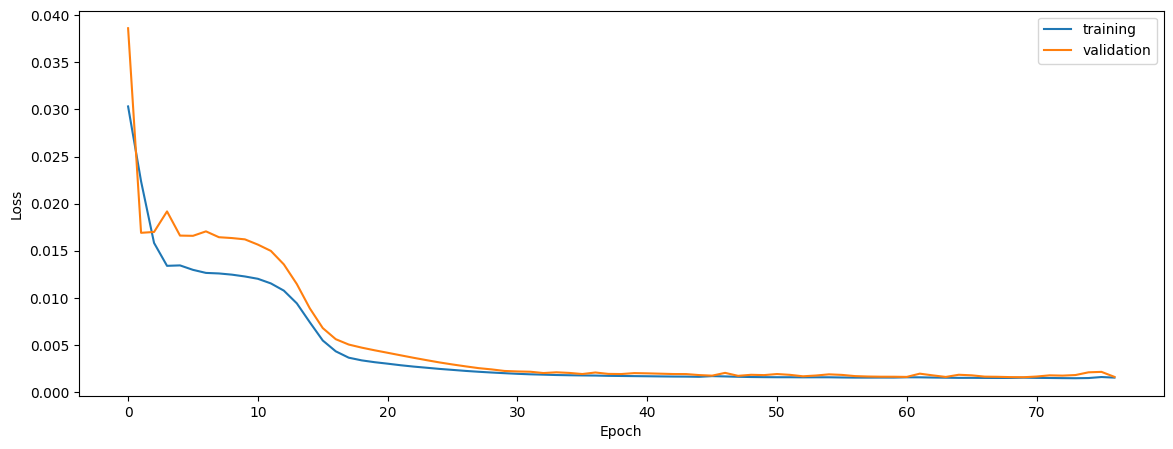

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.9400801040205493
0.9522262791795454
0.9487547144112101


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.9400801040205493
0.9522262791795454
0.9487547144112101


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.9474326074555605
0.9552399500039702
0.9614752866833141


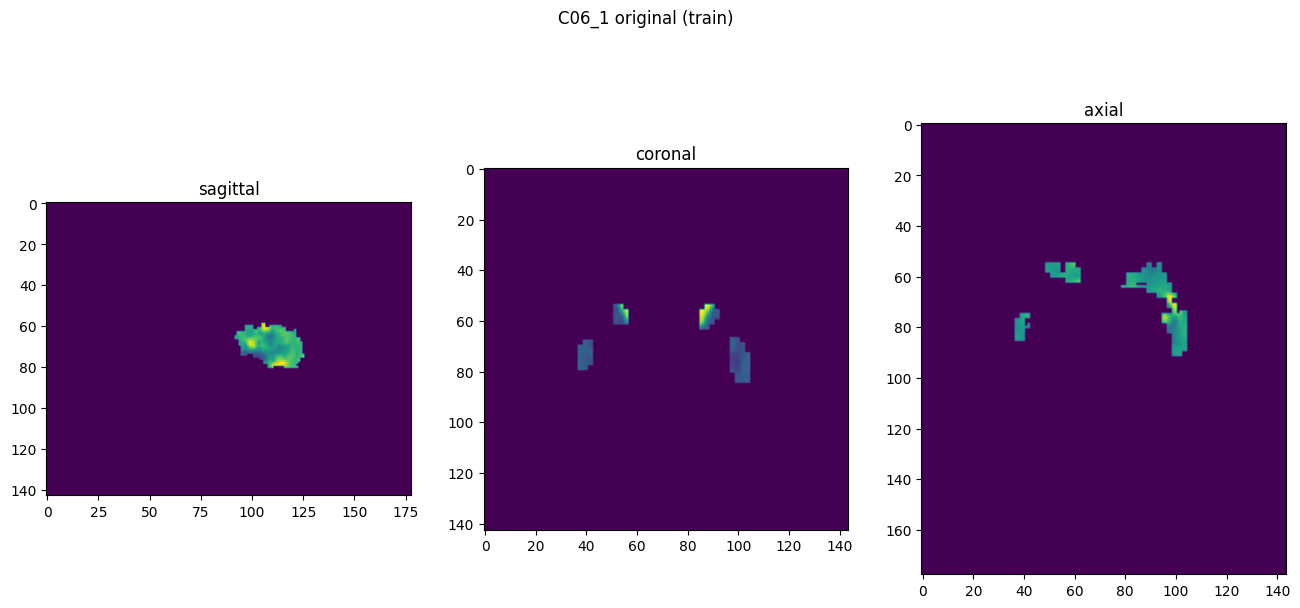

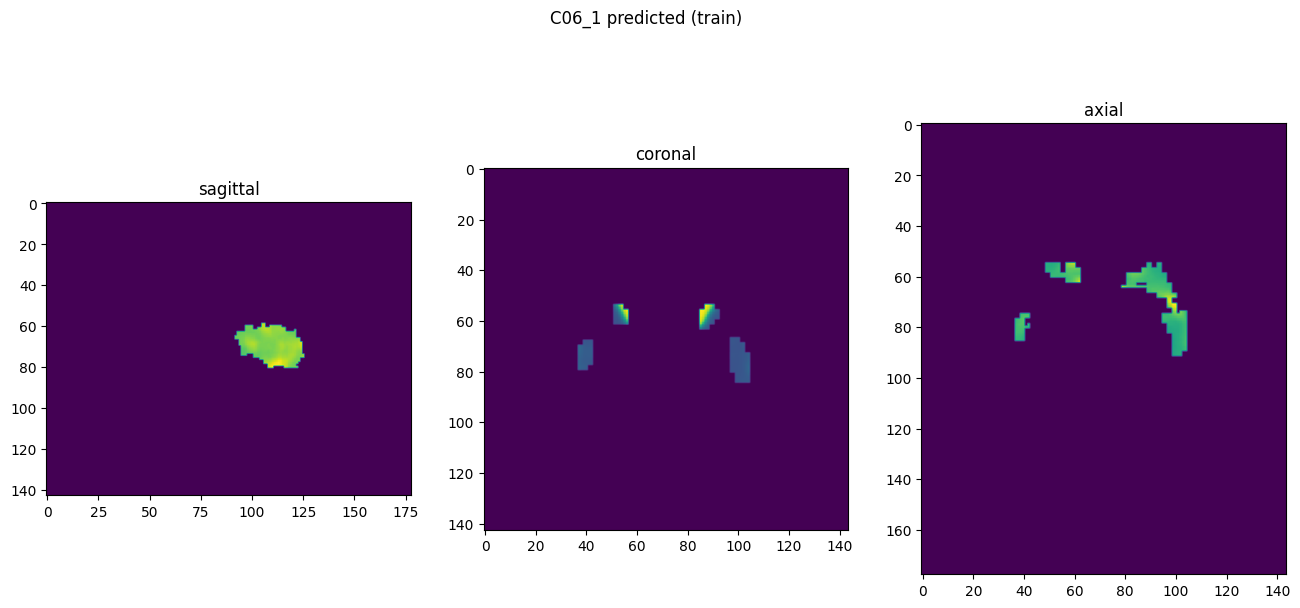

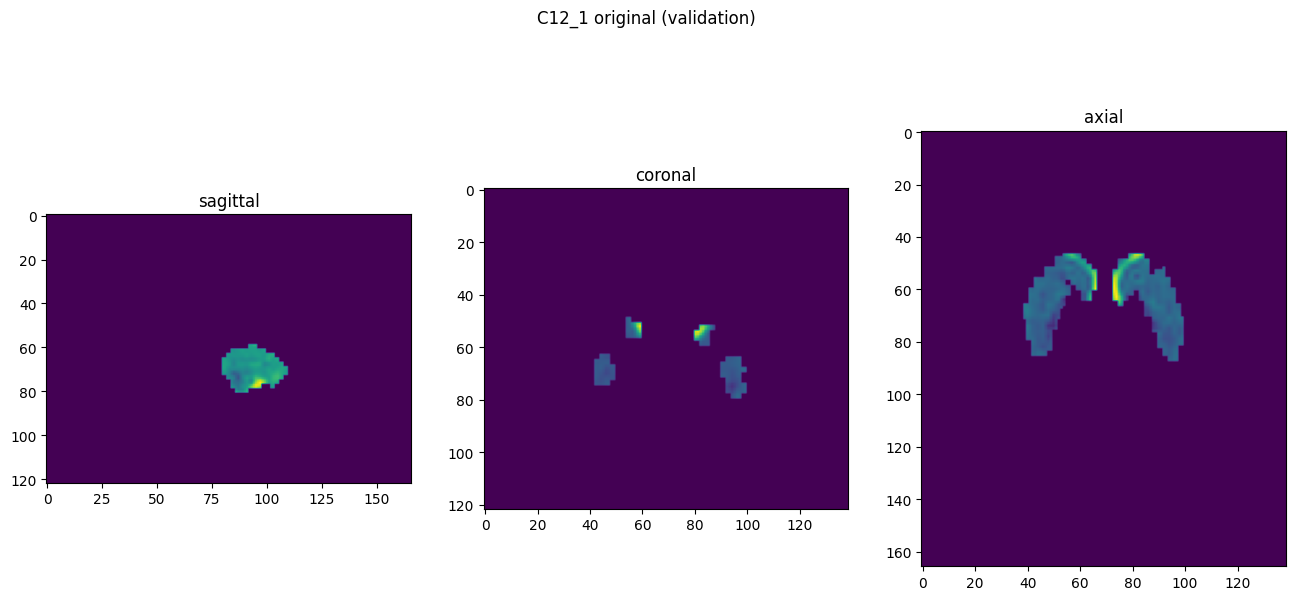

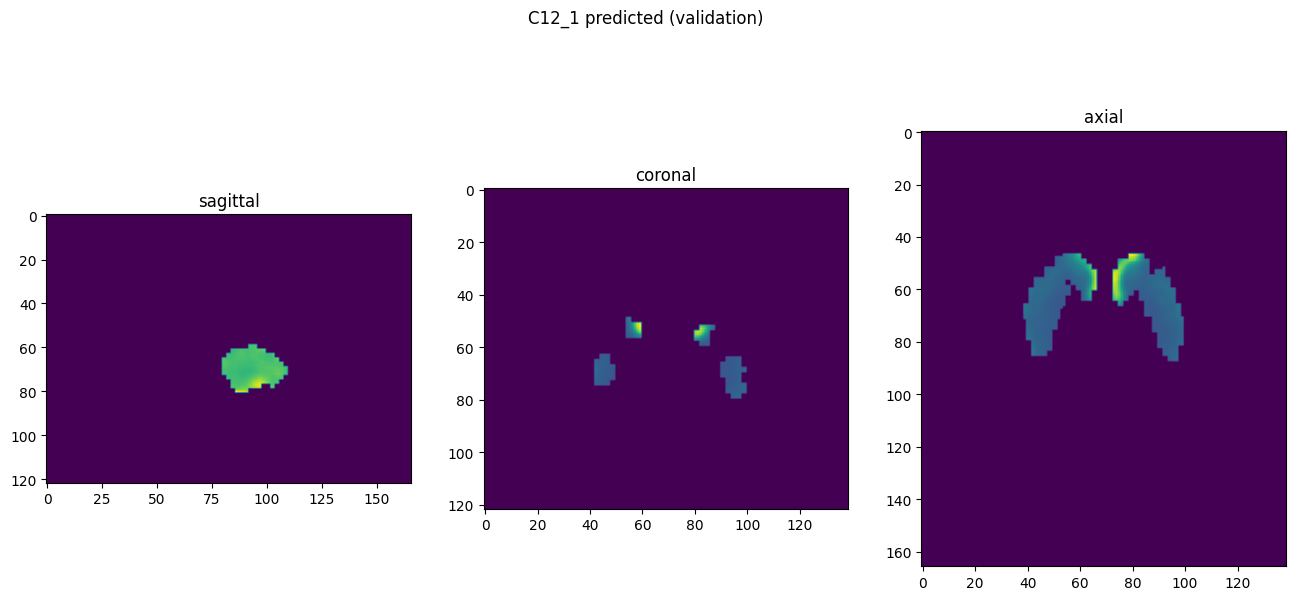

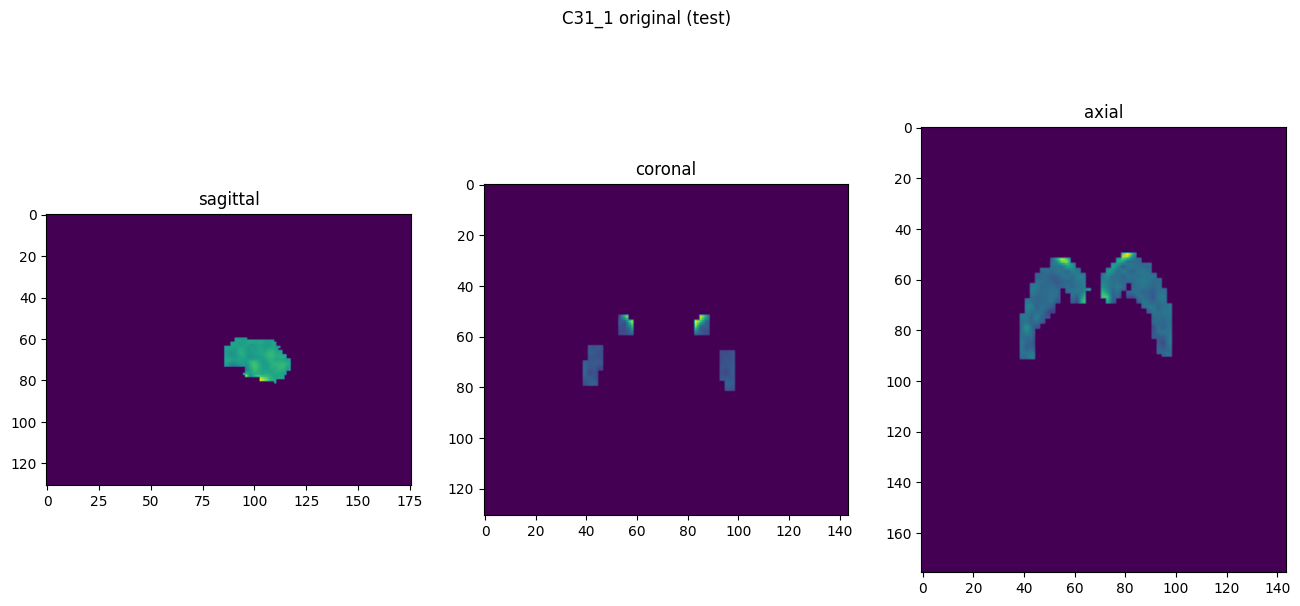

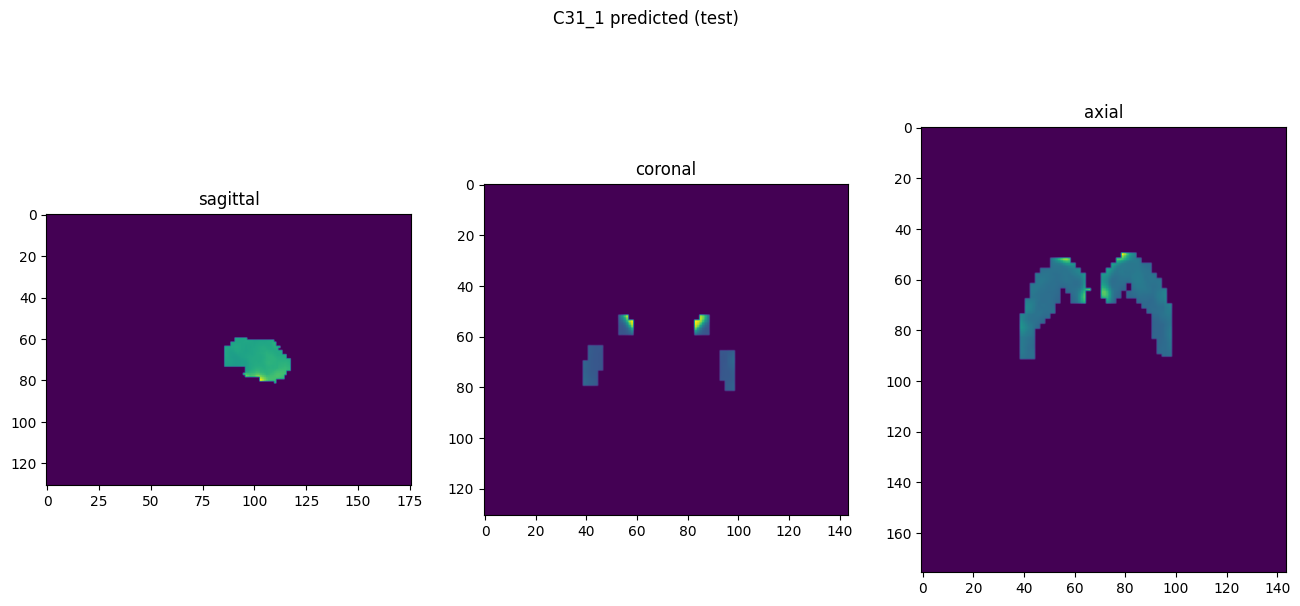

In [10]:
showResults(model, gen, threshold=None, background=False)